In [13]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# All necessary libraries for the project.
# ---------------------------------------------------------------------------------
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold # We might use this later for robustness
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [14]:

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# This class holds all hyperparameters and settings in one place.
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    DATA_DIR = r"D:\Haseeb\Datasets\VLCS" # Make sure this path is correct for your dataset
    DOMAINS = ["Caltech101", "LabelMe", "SUN09", "VOC2007"]
    
    # --- Model & Architecture ---
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 5
    ### CHANGE ###
    NUM_HEADS = 4
    DROPOUT_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4
    OPTIMIZER = "AdamW"
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("---------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# A list to store the final results from each LODO experiment run.
# This will be converted to a DataFrame at the end for analysis.
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2: Data Loading.")

--- Project Configuration ---
DATA_DIR: D:\Haseeb\Datasets\VLCS
DOMAINS: ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 5
NUM_HEADS: 4
DROPOUT_OPTIONS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
BATCH_SIZE: 128
NUM_EPOCHS: 5
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
---------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2: Data Loading.


In [15]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# =================================================================================

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# Define the transformations for training (with augmentation) and validation/testing.
# ---------------------------------------------------------------------------------

# The ViT model was pre-trained on images of size 224x224
IMG_SIZE = 224

# The normalization values are standard for many pre-trained models
# but it's good practice to use the ones specified by the model's authors if available.
# For ViT, a simple (0.5, 0.5, 0.5) normalization is common.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # A simple data augmentation technique
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


In [16]:
# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# This class will read the images and labels from our specific folder structure.
# ---------------------------------------------------------------------------------
import random # Make sure to import the 'random' library at the top of the cell.

class VLCSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        ### CHANGE 2: Add a counter for corrupted images ###
        self.corrupted_images_count = 0
        
        try:
            self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        except FileNotFoundError:
            print(f"Error: Could not find domain folder at {os.path.join(root_dir, domains[0])}")
            print("Please ensure your DATA_DIR and DOMAINS in the Config class are correct.")
            raise

        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                if os.path.isdir(class_path):
                    for img_name in os.listdir(class_path):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
        except (OSError, IOError) as e:
            ### CHANGE 3: Increment the counter and replace with a random image ###
            self.corrupted_images_count += 1
            # You can uncomment the print statement below for verbose debugging if you want
            # print(f"Warning: Corrupted image at {img_path}. Replacing with random. Total corrupt: {self.corrupted_images_count}")
            
            # Pick a new random index
            new_idx = random.randint(0, len(self) - 1)
            # Recursively call __getitem__ with the new index.
            return self.__getitem__(new_idx)

        # The transformation part remains the same
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [17]:
# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = VLCSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [18]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE (SHARED HEAD STRATEGY - with updated logging)
# =================================================================================

class SharedHeadViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rates: list):
        super(SharedHeadViT, self).__init__()
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        hidden_dim = self.vit_backbone.config.hidden_size
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=rate) for rate in dropout_rates])
        self.shared_head = nn.Linear(hidden_dim, num_classes)

    def update_dropout_rates(self, new_rates: list):
        assert len(new_rates) == len(self.dropout_layers), "Number of new rates must match number of dropout layers."
        for i, dropout_layer in enumerate(self.dropout_layers):
            dropout_layer.p = new_rates[i]
            
    def forward(self, images):
        z = self.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        
        path_outputs = {} # Changed from head_outputs
        for i, dropout_layer in enumerate(self.dropout_layers):
            z_dropped = dropout_layer(z)
            logits = self.shared_head(z_dropped)
            
            ### LOGGING CHANGE ###
            # The dictionary key is now 'path_x' for clarity
            path_outputs[f'path_{i+1}'] = logits 
            
        return path_outputs

print("SharedHeadViT class defined with updated logging.")

SharedHeadViT class defined with updated logging.


In [19]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC
# =================================================================================
# =================================================================================
# SECTION 4.1: TRAIN_ONE_EPOCH FUNCTION (FINAL CORRECTED VERSION)
# =================================================================================

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_winner_loss = 0.0
    path_correct_preds = defaultdict(int)
    total_samples = 0
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        ### THE FIX IS HERE ###
        # Move each tensor to the device on its own line.
        images = images.to(device)
        labels = labels.to(device)
        
        z = model.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        z_detached = z.detach()

        path_outputs = {}
        all_losses = {}
        batch_accuracies = {}

        for i, dropout_layer in enumerate(model.dropout_layers):
            path_name = f'path_{i+1}'
            
            live_logits = model.shared_head(dropout_layer(z))
            detached_logits = model.shared_head(dropout_layer(z_detached))

            path_outputs[path_name] = live_logits
            
            all_losses[path_name] = {
                'live': criterion(live_logits, labels),
                'detached': criterion(detached_logits, labels)
            }

            _, preds = torch.max(live_logits, 1)
            correct = torch.sum(preds == labels).item()
            batch_accuracies[path_name] = correct / labels.size(0)

        winner_path_name = max(batch_accuracies, key=batch_accuracies.get)

        final_loss = all_losses[winner_path_name]['live']
        for path_name, loss_dict in all_losses.items():
            if path_name != winner_path_name:
                final_loss += loss_dict['detached']
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()

        total_winner_loss += all_losses[winner_path_name]['live'].item()
        for path_name, logits in path_outputs.items():
             _, preds = torch.max(logits, 1)
             path_correct_preds[path_name] += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    final_path_accuracies = {name: (correct / total_samples) for name, correct in path_correct_preds.items()}
    return {
        "avg_winner_loss": total_winner_loss / len(train_loader),
        "path_accuracies": final_path_accuracies
    }

In [20]:
# ---------------------------------------------------------------------------------
# 4.2: EVALUATE FUNCTION
# (This function is correct and does not need to change)
# ---------------------------------------------------------------------------------
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)
            head_outputs = model(images)
            all_logits = torch.stack(list(head_outputs.values()))
            ensembled_logits = torch.mean(all_logits, dim=0)
            loss = criterion(ensembled_logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(ensembled_logits, 1)
            correct_preds += torch.sum(preds == labels).item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    return {
        "avg_loss": avg_loss,
        "accuracy": accuracy
    }

# --- Quick Test of the Functions (Optional but Recommended) ---
### CHANGE ###
# The test block is now updated to work with the new model __init__
# and the new 80/20 get_dataloaders function.
# ---------------------------------------------------------------------------------
print("Running a quick test of the training and evaluation functions...")

# # We need some dataloaders for the test
# target_domain_test = config.DOMAINS[3] # "sketch"
# train_loader_test, val_loader_test, _ = get_dataloaders(
#     root_dir=config.DATA_DIR,
#     target_domain=target_domain_test,
#     all_domains=config.DOMAINS,
#     batch_size=config.BATCH_SIZE,
#     seed=config.SEED # Pass the seed
# )

# # 1. Generate an initial list of dropout rates for the test
# initial_dropout_rates = list(np.random.choice(
#     config.DROPOUT_OPTIONS, 
#     config.NUM_HEADS, 
#     replace=False
# ))
# print(f"Test model initial dropout rates: {initial_dropout_rates}")

# # 2. Instantiate the model using the LIST of rates
# test_model = EvolutionaryViT(
#     model_name=config.MODEL_NAME,
#     num_classes=config.NUM_CLASSES,
#     dropout_rates=initial_dropout_rates # Pass the list here
# ).to(config.DEVICE)

# test_optimizer = torch.optim.AdamW(test_model.parameters(), lr=config.LEARNING_RATE)
# test_criterion = nn.CrossEntropyLoss()

# # Run one training epoch
# train_metrics = train_one_epoch(test_model, train_loader_test, test_optimizer, test_criterion, config.DEVICE)
# print("\n--- One Training Epoch Test ---")
# print(f"Average Winner Loss: {train_metrics['avg_winner_loss']:.4f}") 
# print("Final Head Accuracies for the Epoch:")
# for name, acc in train_metrics['head_accuracies'].items():
#     print(f"  {name}: {acc:.4f}")

# # Run one evaluation pass
# eval_metrics = evaluate(test_model, val_loader_test, test_criterion, config.DEVICE)
# print("\n--- One Evaluation Pass Test ---")
# print(f"Ensembled Validation Loss: {eval_metrics['avg_loss']:.4f}")
# print(f"Ensembled Validation Accuracy: {eval_metrics['accuracy']:.4f}")

print("\nTraining and evaluation logic seems correct. Ready for Section 5: The Main Experiment Loop.")

Running a quick test of the training and evaluation functions...

Training and evaluation logic seems correct. Ready for Section 5: The Main Experiment Loop.


In [21]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (SHARED HEAD - FINAL CORRECTED VERSION)
# =================================================================================
config = Config()
for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    current_dropout_rates = list(np.random.choice(
        config.DROPOUT_OPTIONS, 
        config.NUM_HEADS, 
        replace=False
    ))
    
    model = SharedHeadViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rates=current_dropout_rates
    ).to(config.DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        print(f"Current Dropout Rates: { {f'path_{i+1}': rate for i, rate in enumerate(current_dropout_rates)} }")
        
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Avg Winner Loss: {train_metrics['avg_winner_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")
        
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())

        ### FIX 1 ###
        # Use the correct key: 'path_accuracies'
        epoch_winner_path_name = max(train_metrics['path_accuracies'], key=train_metrics['path_accuracies'].get)
        epoch_winner_index = int(epoch_winner_path_name.split('_')[-1]) - 1
        
        print(f"  Epoch Training Accuracies:")
        ### FIX 2 ###
        # Use the correct key: 'path_accuracies'
        for name, acc in sorted(train_metrics['path_accuracies'].items()):
            ### FIX 3 ###
            # Compare to the correct variable name: epoch_winner_path_name
            marker = "<- WINNER" if name == epoch_winner_path_name else ""
            print(f"    {name}: {acc:.4f} {marker}")
        
        winner_rate = current_dropout_rates[epoch_winner_index]
        new_random_rates = list(np.random.choice(config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False))
        new_random_rates[epoch_winner_index] = winner_rate
        current_dropout_rates = new_random_rates
        model.update_dropout_rates(current_dropout_rates)
            
    # --- Final Evaluation and Storing Results (No changes needed here) ---
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    model.load_state_dict(best_model_state)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")
    
    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = CALTECH101
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: Caltech101
Source Domains for Train/Val: ['LabelMe', 'SUN09', 'VOC2007']
Source data size: 9314
  -> Training on: 7451 images (80%)
  -> Validating on: 1863 images (20%)
Testing on full 'Caltech101' domain: 1415 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.2), 'path_3': np.float64(0.6), 'path_4': np.float64(0.3)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 3.8181
  Validation Loss: 0.5147
  Validation Accuracy: 0.8148
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.7225 <- WINNER
    path_2: 0.7161 
    path_3: 0.6289 
    path_4: 0.7019 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.1), 'path_3': np.float64(0.4), 'path_4': np.float64(0.3)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.8343
  Validation Loss: 0.4826
  Validation Accuracy: 0.8218
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.8415 
    path_2: 0.8446 <- WINNER
    path_3: 0.8153 
    path_4: 0.8247 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.1), 'path_3': np.float64(0.7), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 1.6990
  Validation Loss: 0.5455
  Validation Accuracy: 0.8154
  Epoch Training Accuracies:
    path_1: 0.9019 <- WINNER
    path_2: 0.8992 
    path_3: 0.7812 
    path_4: 0.8241 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.3), 'path_3': np.float64(0.7), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 1.2989
  Validation Loss: 0.6410
  Validation Accuracy: 0.8175
  Epoch Training Accuracies:
    path_1: 0.9297 <- WINNER
    path_2: 0.9223 
    path_3: 0.8317 
    path_4: 0.8746 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.3), 'path_3': np.float64(0.2), 'path_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.7527
  Validation Loss: 0.7259
  Validation Accuracy: 0.8229
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9564 <- WINNER
    path_2: 0.9475 
    path_3: 0.9520 
    path_4: 0.8764 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CALTECH101 ---
  Test Accuracy: 0.9413
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = LABELME
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: LabelMe
Source Domains for Train/Val: ['Caltech101', 'SUN09', 'VOC2007']
Source data size: 8073
  -> Training on: 6458 images (80%)
  -> Validating on: 1615 images (20%)
Testing on full 'LabelMe' domain: 2656 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.6), 'path_3': np.float64(0.3), 'path_4': np.float64(0.5)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 3.8245
  Validation Loss: 0.4082
  Validation Accuracy: 0.8570
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.7924 <- WINNER
    path_2: 0.6929 
    path_3: 0.7572 
    path_4: 0.7216 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.2), 'path_3': np.float64(0.5), 'path_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.3726
  Validation Loss: 0.3899
  Validation Accuracy: 0.8755
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9051 <- WINNER
    path_2: 0.8992 
    path_3: 0.8444 
    path_4: 0.8693 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.7), 'path_3': np.float64(0.4), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 1.3040
  Validation Loss: 0.4321
  Validation Accuracy: 0.8588
  Epoch Training Accuracies:
    path_1: 0.9415 <- WINNER
    path_2: 0.8365 
    path_3: 0.9158 
    path_4: 0.8771 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.3), 'path_3': np.float64(0.6), 'path_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.7992
  Validation Loss: 0.4314
  Validation Accuracy: 0.8786
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.9748 <- WINNER
    path_2: 0.9650 
    path_3: 0.9190 
    path_4: 0.8876 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.3), 'path_3': np.float64(0.5), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.4364
  Validation Loss: 0.4875
  Validation Accuracy: 0.8743
  Epoch Training Accuracies:
    path_1: 0.9799 <- WINNER
    path_2: 0.9724 
    path_3: 0.9542 
    path_4: 0.9402 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: LABELME ---
  Test Accuracy: 0.6604
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SUN09
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: SUN09
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'VOC2007']
Source data size: 7447
  -> Training on: 5957 images (80%)
  -> Validating on: 1490 images (20%)
Testing on full 'SUN09' domain: 3282 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': np.float64(0.7), 'path_2': np.float64(0.3), 'path_3': np.float64(0.5), 'path_4': np.float64(0.2)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 4.1385
  Validation Loss: 0.4784
  Validation Accuracy: 0.8188
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.6401 
    path_2: 0.7375 
    path_3: 0.7072 
    path_4: 0.7526 <- WINNER

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': np.float64(0.3), 'path_2': np.float64(0.1), 'path_3': np.float64(0.5), 'path_4': np.float64(0.2)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.5438
  Validation Loss: 0.4294
  Validation Accuracy: 0.8530
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.8590 
    path_2: 0.8691 <- WINNER
    path_3: 0.8301 
    path_4: 0.8642 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.1), 'path_3': np.float64(0.5), 'path_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 1.1047
  Validation Loss: 0.4830
  Validation Accuracy: 0.8443
  Epoch Training Accuracies:
    path_1: 0.9060 <- WINNER
    path_2: 0.9055 
    path_3: 0.8776 
    path_4: 0.8864 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': np.float64(0.1), 'path_2': np.float64(0.3), 'path_3': np.float64(0.2), 'path_4': np.float64(0.1)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.7763
  Validation Loss: 0.5286
  Validation Accuracy: 0.8483
  Epoch Training Accuracies:
    path_1: 0.9303 
    path_2: 0.9206 
    path_3: 0.9278 
    path_4: 0.9313 <- WINNER

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': np.float64(0.4), 'path_2': np.float64(0.6), 'path_3': np.float64(0.1), 'path_4': np.float64(0.1)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.5648
  Validation Loss: 0.6070
  Validation Accuracy: 0.8477
  Epoch Training Accuracies:
    path_1: 0.9490 
    path_2: 0.9199 
    path_3: 0.9642 
    path_4: 0.9654 <- WINNER

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SUN09 ---
  Test Accuracy: 0.7770
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = VOC2007
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: VOC2007
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'SUN09']
Source data size: 7353
  -> Training on: 5882 images (80%)
  -> Validating on: 1471 images (20%)
Testing on full 'VOC2007' domain: 3376 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'path_1': np.float64(0.2), 'path_2': np.float64(0.4), 'path_3': np.float64(0.3), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 3.3321
  Validation Loss: 0.4955
  Validation Accuracy: 0.8171
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.7599 <- WINNER
    path_2: 0.7373 
    path_3: 0.7365 
    path_4: 0.6678 

--- Epoch 2/5 ---
Current Dropout Rates: {'path_1': np.float64(0.2), 'path_2': np.float64(0.2), 'path_3': np.float64(0.7), 'path_4': np.float64(0.5)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 1.9453
  Validation Loss: 0.4807
  Validation Accuracy: 0.8266
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    path_1: 0.8529 <- WINNER
    path_2: 0.8519 
    path_3: 0.7644 
    path_4: 0.8274 

--- Epoch 3/5 ---
Current Dropout Rates: {'path_1': np.float64(0.2), 'path_2': np.float64(0.2), 'path_3': np.float64(0.5), 'path_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 1.3633
  Validation Loss: 0.5121
  Validation Accuracy: 0.8199
  Epoch Training Accuracies:
    path_1: 0.8912 
    path_2: 0.8948 <- WINNER
    path_3: 0.8694 
    path_4: 0.8591 

--- Epoch 4/5 ---
Current Dropout Rates: {'path_1': np.float64(0.6), 'path_2': np.float64(0.2), 'path_3': np.float64(0.3), 'path_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 0.8546
  Validation Loss: 0.6004
  Validation Accuracy: 0.8239
  Epoch Training Accuracies:
    path_1: 0.9048 
    path_2: 0.9368 <- WINNER
    path_3: 0.9318 
    path_4: 0.9281 

--- Epoch 5/5 ---
Current Dropout Rates: {'path_1': np.float64(0.6), 'path_2': np.float64(0.2), 'path_3': np.float64(0.3), 'path_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 0.7566
  Validation Loss: 0.7655
  Validation Accuracy: 0.8158
  Epoch Training Accuracies:
    path_1: 0.9284 
    path_2: 0.9504 <- WINNER
    path_3: 0.9487 
    path_4: 0.9060 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: VOC2007 ---
  Test Accuracy: 0.7435
--------------------------------------------------


          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE


--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0    Caltech101       0.941343           0.822866           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       LabelMe       0.660392           0.878638           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         SUN09       0.776965           0.853020           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
3       VOC2007       0.743483           0.826649           5         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7805


C:\Users\Haseeb\AppData\Local\Temp\ipykernel_43268\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


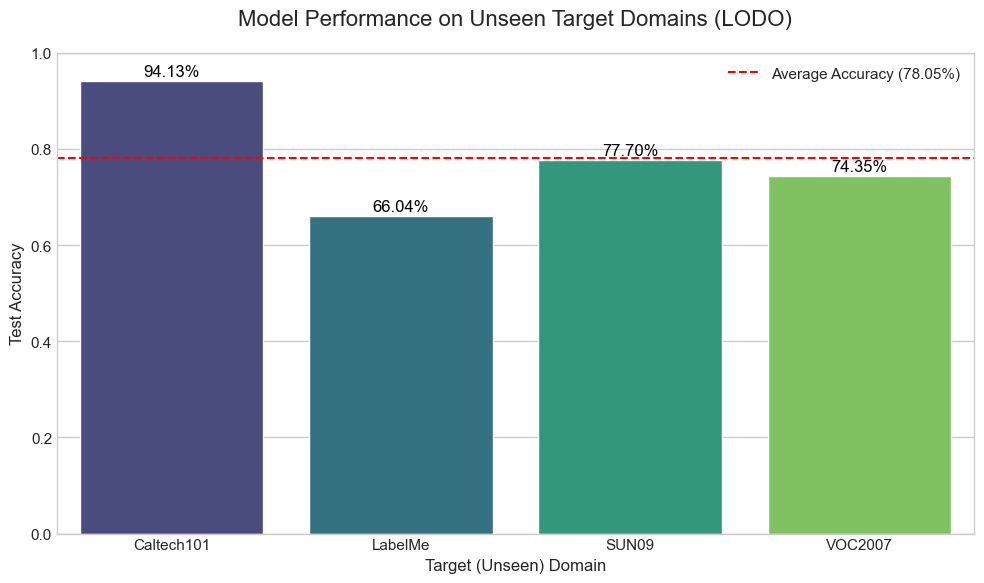


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007'],
    'test_accuracy': [0.9413, 0.6604, 0.777, 0.7435]
}

--- Experiment Complete ---


In [21]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")

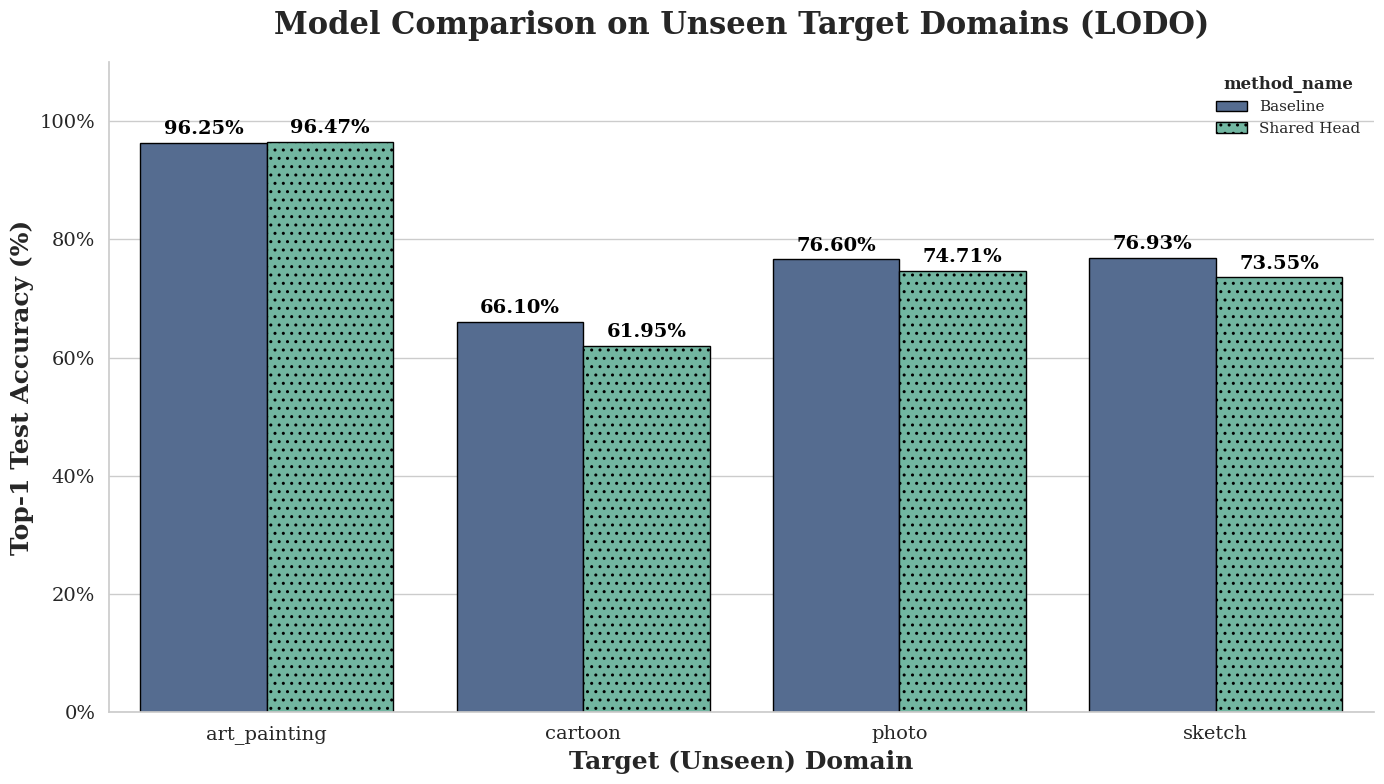


--- Average Performance Summary ---
Average Baseline Accuracy: 78.97%
Average Evolutionary Dropout Accuracy: 76.67%


In [22]:
# =================================================================================
# SECTION 7: COMPARATIVE ANALYSIS & VISUALIZATION (ACADEMIC STYLE - FINAL FIX)
# =================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7.1: COMBINE EXPERIMENT RESULTS ---
baseline_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.9625, 0.661, 0.766, 0.7693]
}
# Using the results from your successful Option 4 run
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.9647, 0.6195, 0.7471, 0.7355]
}
baseline_df = pd.DataFrame(baseline_results)
baseline_df['method_name'] = 'Baseline'
evolutionary_df = pd.DataFrame(evolutionary_results)
evolutionary_df['method_name'] = 'Shared Head'
combined_df = pd.concat([baseline_df, evolutionary_df])

# --- 7.2: CREATE THE GROUPED BAR CHART (ROBUST VERSION) ---

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

custom_palette = {'Baseline': '#4B6A9A', 'Shared Head': '#66C2A5'}

barplot = sns.barplot(
    data=combined_df,
    x='target_domain',
    y='test_accuracy',
    hue='method_name',
    ax=ax,
    palette=custom_palette,
    edgecolor='black'
)

### THE FIX IS HERE ###
# Use the robust 'containers' method to apply patterns correctly.

# ax.containers[0] is the container for the first hue category (Baseline)
# ax.containers[1] is the container for the second hue category (Evolutionary Dropout)

# We want to add a pattern to the second container's bars.
for bar in ax.containers[1]:
    bar.set_hatch('..')

# We also need to apply the pattern to the corresponding legend handle.
# The legend handles are created in the same order.
ax.legend_.legend_handles[1].set_hatch('..')

# --- Add annotations (text on bars) ---
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --- Final plot styling ---
ax.set_title('Model Comparison on Unseen Target Domains (LODO)', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=18, fontweight='bold')
ax.set_ylabel('Top-1 Test Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

legend = ax.get_legend()
plt.setp(legend.get_title(), fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# --- Print the final summary table ---
avg_baseline = baseline_df['test_accuracy'].mean()
avg_evolutionary = evolutionary_df['test_accuracy'].mean()
print("\n--- Average Performance Summary ---")
print(f"Average Baseline Accuracy: {avg_baseline:.2%}")
print(f"Average Evolutionary Dropout Accuracy: {avg_evolutionary:.2%}")